In [1]:
from pathlib import Path
from copy import deepcopy

import numpy as np

from astropy import units as u
from astropy import constants as cnst
from astropy.io import fits
from astropy import modeling

from specutils import Spectrum1D, manipulation

from astropy.visualization import quantity_support
quantity_support()

from matplotlib import pyplot as plt

from tqdm.notebook import tqdm

In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [3]:
datapath = Path('../fullgrid/')

In [4]:
wlspath = datapath / 'WAVE_PHOENIX-ACES-AGSS-COND-2011.fits'

wlsraw = fits.getdata(wlspath)
wls = wlsraw << u.Unit(fits.getheader(wlspath)['UNIT'])

wls

<Quantity [  500.  ,   500.1 ,   500.2 , ..., 54999.25, 54999.5 , 54999.75] Angstrom>

In [5]:
allspecpaths = list(datapath.glob('lte*HiRes.fits'))
len(allspecpaths)

7559

In [6]:
f1 = [p for p in allspecpaths if int(str(p).split('lte')[1].split('-')[0]) == 5800]
f2 = [p for p in f1 if '0.0.PHOENIX' in str(p)]
f3 = [p for p in f2 if '-4.50-' in str(p)]
assert len(f3)==1
solaranalog = fits.open(f3[0])
ssolaranalog = Spectrum1D(spectral_axis=wls, flux=solaranalog[0].data << u.Unit(solaranalog[0].header['BUNIT']))

# Single-spectrum, pixel offset

this is a proof-of-concept for doing inter-pixel interpoaltion faster than the above

In [7]:
def make_data(resampler, s1d, n, pixamp=1, npx=2048, wlbnds=(10000, 20000)*u.angstrom, random=True, progress=False):
    newl0 = np.linspace(wlbnds[0], wlbnds[1], npx)
    if random:
        offsets = np.random.rand(n) - .5
    else:
        offsets = np.arange(n)/n - .5
    offsets = offsets * pixamp * np.diff(newl0)[0]
    newls = newl0 + offsets[..., None]

    if progress:
        def progress(x):
            p = tqdm(x)
            if random:
                p.set_description('making random data')
            else:
                p.set_description('making ordered data')
            return p
    else:
        progress = lambda x: x
        
    resampled_specs = [resampler(s1d, newl) for newl in progress(newls)]

    return offsets, resampled_specs

In [15]:
%%time
offsets, spec =  make_data(manipulation.FluxConservingResampler() ,ssolaranalog, 100)

CPU times: user 10.3 s, sys: 459 ms, total: 10.7 s
Wall time: 10.8 s


In [16]:
10000/10/60

16.666666666666668

So can make 10000 in 15 min

Try training a simple neural network to emulate sub-pixel offsets.

In [8]:
class SpectralNeuralNetwork(nn.Module):
    def __init__(self, basespectrum, pixamp=1, npix=2048, wlbnds=(10000, 20000)*u.angstrom, inner_layers=[512, 512], outscale='guess'):
        super().__init__()

        last_layern = 1
        
        stack = [nn.BatchNorm1d(last_layern)]
        
        for nneurons in inner_layers:
            stack.append(nn.Linear(last_layern, nneurons))
            stack.append(nn.GELU())
            last_layern = nneurons
        stack.append(nn.Linear(last_layern, npix))
                     
        
        self.stack = nn.Sequential(*stack)
        
        self.basespectrum =  basespectrum  
        self.resampler = manipulation.FluxConservingResampler()
        self.pixamp = pixamp
        self.npix = npix
        self.wlbnds = wlbnds

        if outscale == 'guess':
            self.outscale = 1
            _, y, _ = self.make_data(2, random=False)
            self.outscale = (1/y.max()).cpu().numpy()
        else:
            self.outscale = outscale
            

    @property
    def device(self):
        return next(self.parameters()).device
        
    def make_data(self, nbatch, random=True, progress=False):
        model_dtype = next(self.parameters()).dtype
        
        offsets, resampled_specs = make_data(self.resampler, self.basespectrum, nbatch, self.pixamp, self.npix, self.wlbnds, random=random, progress=progress)
        
        offsetsT = torch.tensor(offsets[..., None], dtype=model_dtype).to(self.device)
        resampled_specsT = torch.tensor(np.array([s.flux.value for s in resampled_specs]) * self.outscale, dtype=model_dtype).to(self.device)
        
        return offsetsT, resampled_specsT, resampled_specs
        

    def forward(self, x):
        return self.stack(x)

  0%|          | 0/15 [00:00<?, ?it/s]

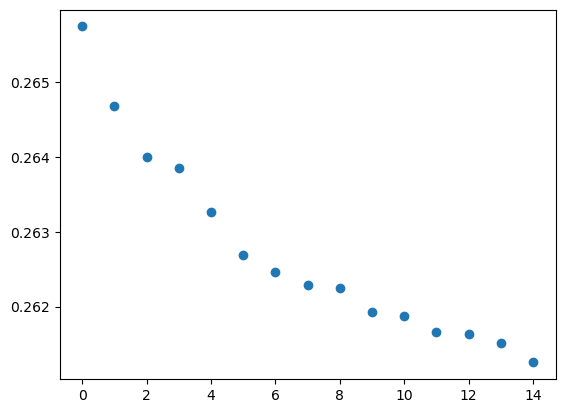

In [108]:
model = SpectralNeuralNetwork(ssolaranalog).to(device)

learning_rate = 1e-3
nbatches = 15
batch_size = 32

loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

test_X, test_Y, _ = model.make_data(10, random=False)[]

test_losses = []
for _ in (pbar := tqdm(range(nbatches))):
    model.train()
    X, Y, _ = model.make_data(batch_size)
    pred = model(X)
    loss = loss_fn(pred, Y)
    
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    model.eval()
    with torch.no_grad():
        pred = model(test_X)
        test_loss = loss_fn(pred,test_Y).item()
        pbar.set_description(f'loss={test_loss}')
        test_losses.append(test_loss)

plt.plot(test_losses, 'o')

Working but horrendously slow to generate the data in the loop.  Lets instead generate a set and pull from those

In [153]:
model = SpectralNeuralNetwork(ssolaranalog).to(device)

test_X, test_Y, test_specs = model.make_data(50, random=False, progress=True)

train_X, train_Y = model.make_data(64*4, random=False, progress=True)[:2]
train_data = TensorDataset(train_X, train_Y)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

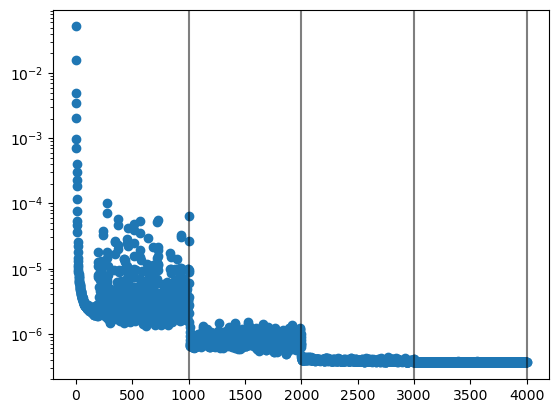

In [192]:
model = SpectralNeuralNetwork(ssolaranalog, inner_layers=[1024, 512, 1024]).to(device)

learning_rates = [1e-3, 1e-4, 1e-5, 1e-6]
nepochs = 1000
batch_size = 64

loss_fn = nn.MSELoss()
test_losses = []

for learning_rate in learning_rates:
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    
    for _ in (pbar := tqdm(range(nepochs))):
        model.train()
    
        for X, Y in DataLoader(train_data, batch_size=batch_size, shuffle=True):
            pred = model(X)
            loss = loss_fn(pred, Y)
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
    
        model.eval()
        with torch.no_grad():
            pred = model(test_X)
            test_loss = loss_fn(pred,test_Y).item()
            pbar.set_description(f'test loss={test_loss}')
            test_losses.append(test_loss)

plt.semilogy(test_losses, 'o')
if len(learning_rates) > 1:
    for i in range(len(learning_rates)):
        plt.axvline((i+1)*nepochs, c='k', alpha=.5)

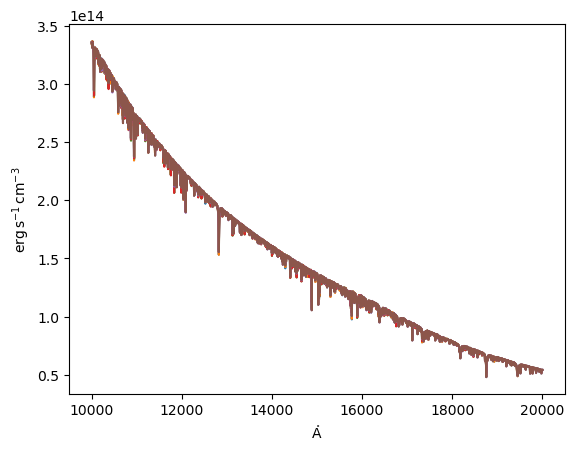

In [193]:
for Xi, s in zip(test_X[::20], test_specs[::20]):
    plt.plot(s.spectral_axis, s.flux)

    modflux = model(Xi[..., None]).detach().cpu().numpy()[0]/model.outscale
    plt.plot(s.spectral_axis, modflux)

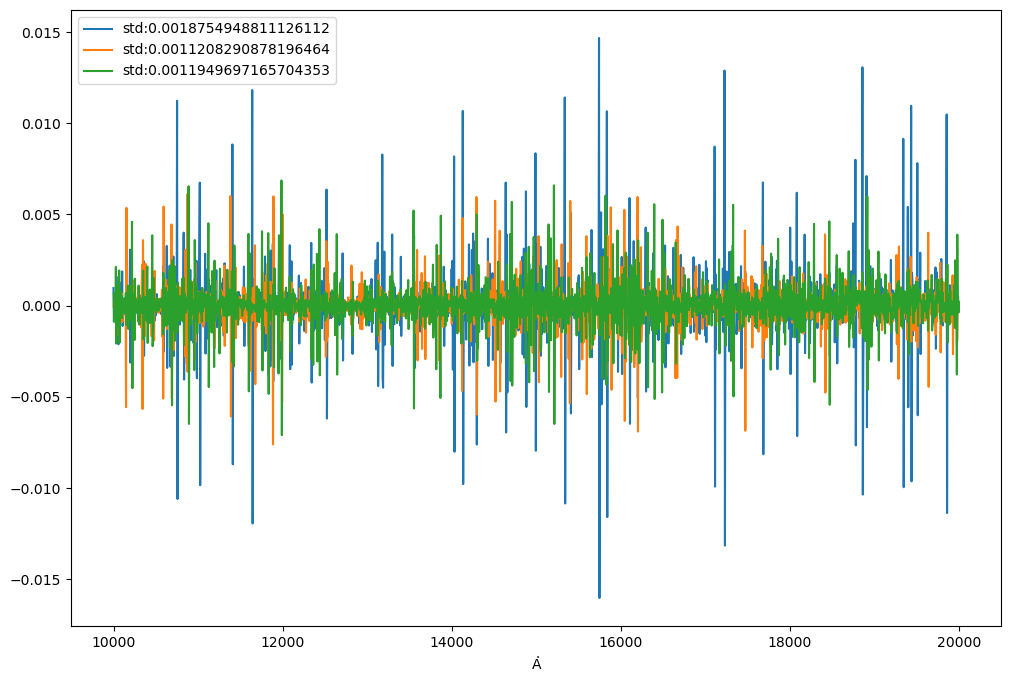

In [194]:
plt.figure(figsize=(12, 8))
for Xi, s in zip(test_X[::20], test_specs[::20]):
    modflux = model(Xi[..., None]).detach().cpu().numpy()[0]/model.outscale
    res = 1 - modflux/s.flux.value
    plt.plot(s.spectral_axis, res, label=f'std:{np.std(res)}')
plt.legend(loc=0)

So this emulator is good to ~.2% or S/N of 500.  Even with the comically oversized neural network, it also does 64*232 it/s = 67 us run time on a RTX 3080 (at ~50% utilization)

Can we do better with float64?

In [9]:
torch.set_default_dtype(torch.float64) # just in case we miss  some

In [12]:
model0 = SpectralNeuralNetwork(ssolaranalog, inner_layers=[1024, 512,1024]).to(device).to(torch.float64)

test_X, test_Y, test_specs = model0.make_data(50, random=False, progress=True)

train_X, train_Y = model0.make_data(64*4, random=False, progress=True)[:2]
train_data = TensorDataset(train_X, train_Y)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

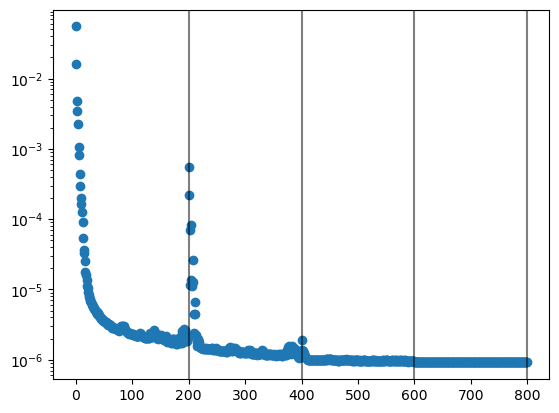

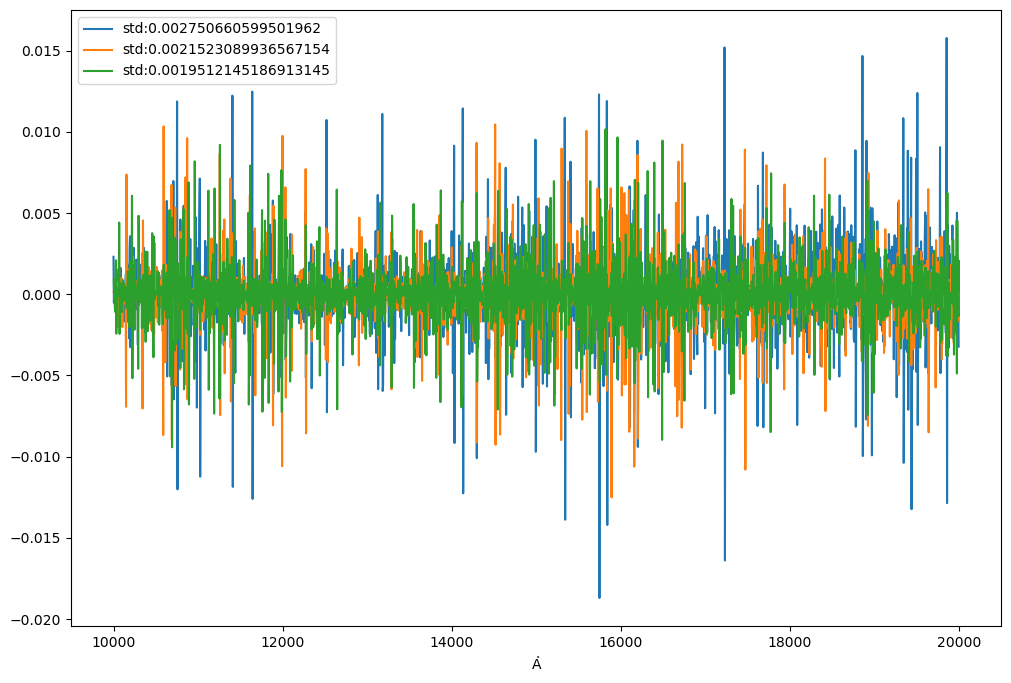

In [24]:
model = deepcopy(model0)

learning_rates = [1e-3, 1e-4, 1e-5, 1e-6]
nepochs = 200
batch_size = 64

loss_fn = nn.MSELoss()
test_losses = []

for learning_rate in learning_rates:
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    
    for _ in (pbar := tqdm(range(nepochs))):
        model.train()
    
        for X, Y in DataLoader(train_data, batch_size=batch_size, shuffle=True):
            pred = model(X)
            loss = loss_fn(pred, Y)
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
    
        model.eval()
        with torch.no_grad():
            pred = model(test_X)
            test_loss = loss_fn(pred,test_Y).item()
            pbar.set_description(f'test loss={test_loss}')
            test_losses.append(test_loss)

plt.semilogy(test_losses, 'o')
if len(learning_rates) > 1:
    for i in range(len(learning_rates)):
        plt.axvline((i+1)*nepochs, c='k', alpha=.5)

plt.figure(figsize=(12, 8))
for Xi, s in zip(test_X[::20], test_specs[::20]):
    modflux = model(Xi[..., None]).detach().cpu().numpy()[0]/model.outscale
    res = 1 - modflux/s.flux.value
    plt.plot(s.spectral_axis, res, label=f'std:{np.std(res)}')
plt.legend(loc=0)

Not really? Odd. More data?

In [10]:
model0 = SpectralNeuralNetwork(ssolaranalog, inner_layers=[1024, 512,1024]).to(device).to(torch.float64)

test_X, test_Y, test_specs = model0.make_data(50, random=False, progress=True)

train_X, train_Y = model0.make_data(64*8, random=False, progress=True)[:2]
train_data = TensorDataset(train_X, train_Y)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/512 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

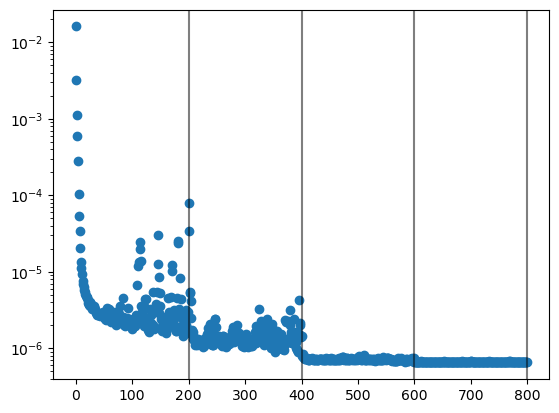

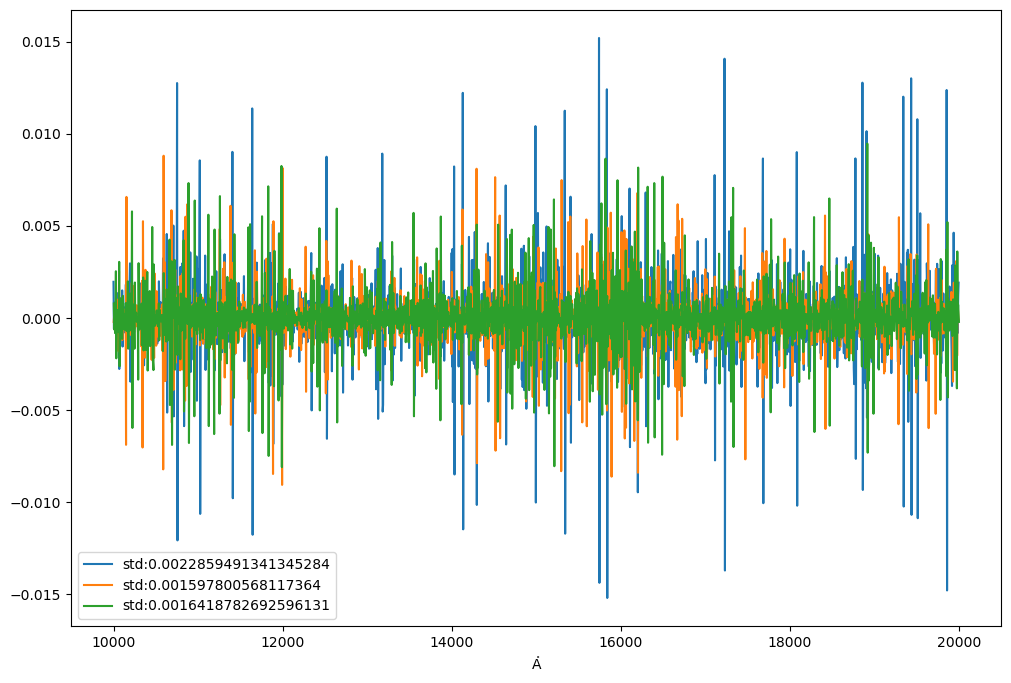

In [245]:
model = deepcopy(model0)

learning_rates = [1e-3, 1e-4, 1e-5, 1e-6]
nepochs = 200
batch_size = 64

loss_fn = nn.MSELoss()
test_losses = []

for learning_rate in learning_rates:
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    
    for _ in (pbar := tqdm(range(nepochs))):
        model.train()
    
        for X, Y in DataLoader(train_data, batch_size=batch_size, shuffle=True):
            pred = model(X)
            loss = loss_fn(pred, Y)
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
    
        model.eval()
        with torch.no_grad():
            pred = model(test_X)
            test_loss = loss_fn(pred,test_Y).item()
            pbar.set_description(f'test loss={test_loss}')
            test_losses.append(test_loss)

plt.semilogy(test_losses, 'o')
if len(learning_rates) > 1:
    for i in range(len(learning_rates)):
        plt.axvline((i+1)*nepochs, c='k', alpha=.5)

plt.figure(figsize=(12, 8))
for Xi, s in zip(test_X[::20], test_specs[::20]):
    modflux = model(Xi[..., None]).detach().cpu().numpy()[0]/model.outscale
    res = 1 - modflux/s.flux.value
    plt.plot(s.spectral_axis, res, label=f'std:{np.std(res)}')
plt.legend(loc=0)

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

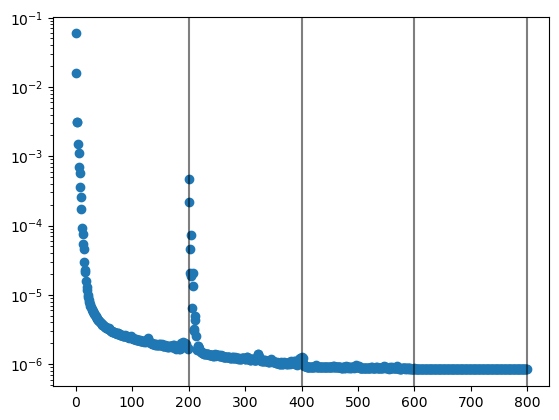

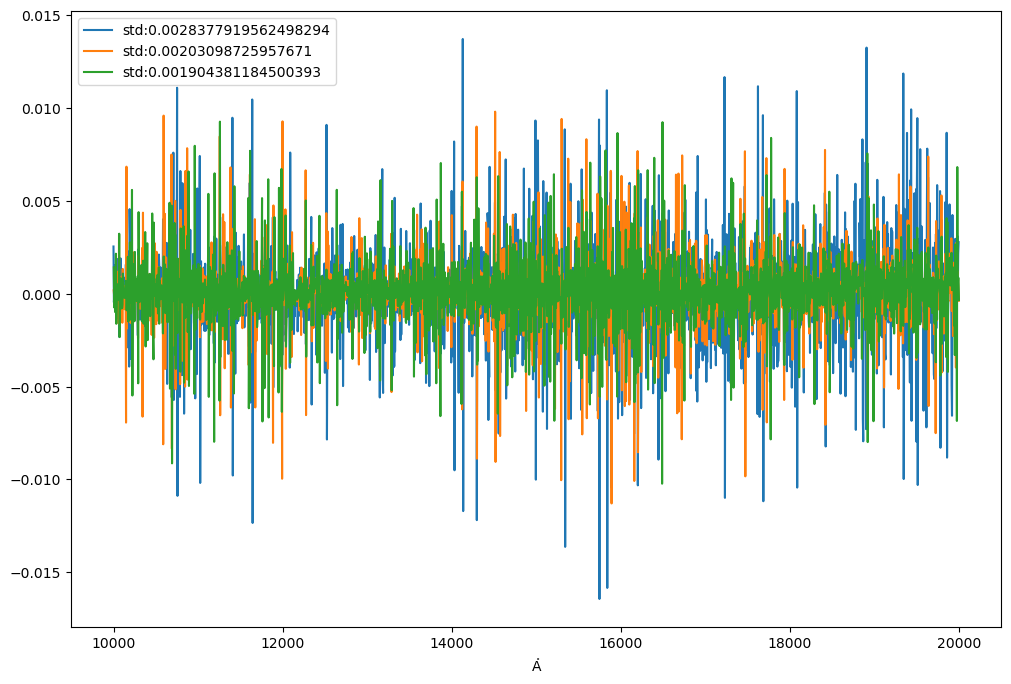

In [246]:
model = deepcopy(model0)

learning_rates = [1e-3, 1e-4, 1e-5, 1e-6]
nepochs = 200
batch_size = 128

loss_fn = nn.MSELoss()
test_losses = []

for learning_rate in learning_rates:
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    
    for _ in (pbar := tqdm(range(nepochs))):
        model.train()
    
        for X, Y in DataLoader(train_data, batch_size=batch_size, shuffle=True):
            pred = model(X)
            loss = loss_fn(pred, Y)
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
    
        model.eval()
        with torch.no_grad():
            pred = model(test_X)
            test_loss = loss_fn(pred,test_Y).item()
            pbar.set_description(f'test loss={test_loss}')
            test_losses.append(test_loss)

plt.semilogy(test_losses, 'o')
if len(learning_rates) > 1:
    for i in range(len(learning_rates)):
        plt.axvline((i+1)*nepochs, c='k', alpha=.5)

plt.figure(figsize=(12, 8))
for Xi, s in zip(test_X[::20], test_specs[::20]):
    modflux = model(Xi[..., None]).detach().cpu().numpy()[0]/model.outscale
    res = 1 - modflux/s.flux.value
    plt.plot(s.spectral_axis, res, label=f'std:{np.std(res)}')
plt.legend(loc=0)

Confirm on CPU (although a lot slower):

In [259]:
model0 = SpectralNeuralNetwork(ssolaranalog, inner_layers=[1024, 512,1024]).to('cpu').to(torch.float64)

test_X, test_Y, test_specs = model0.make_data(50, random=False, progress=True)

train_X, train_Y = model0.make_data(64*4, random=False, progress=True)[:2]
train_data = TensorDataset(train_X, train_Y)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

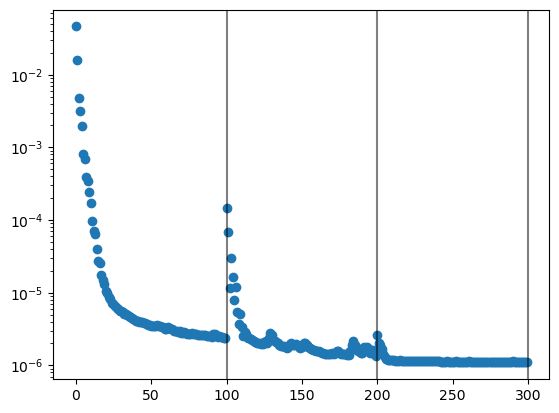

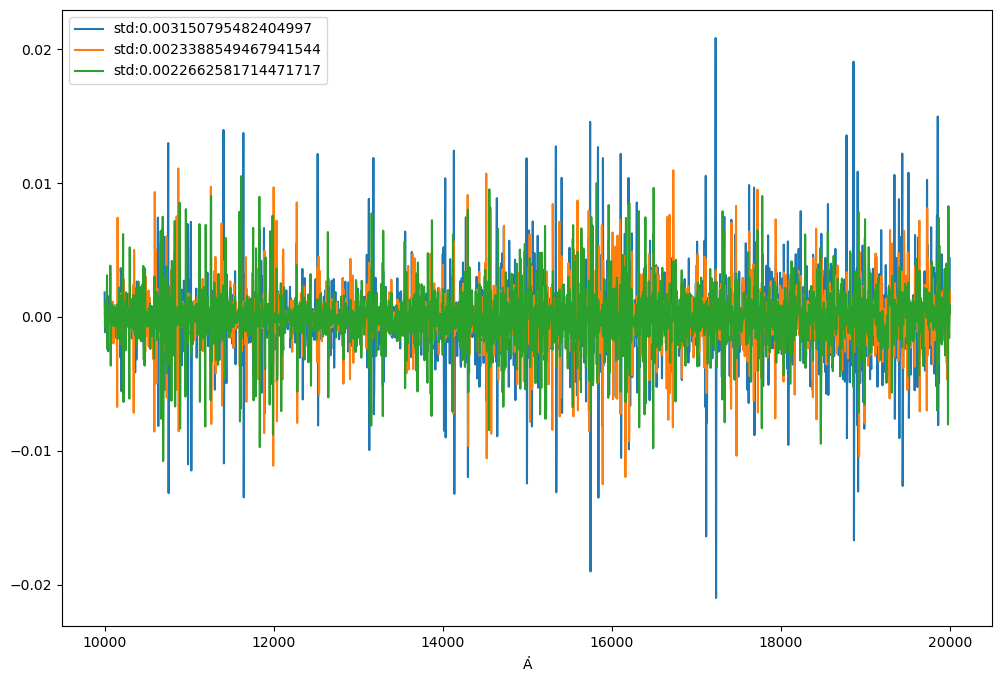

In [273]:
model = deepcopy(model0)

learning_rates = [1e-3, 1e-4, 1e-5]
nepochs = 100
batch_size = 64

loss_fn = nn.MSELoss()
test_losses = []

for learning_rate in learning_rates:
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    
    for _ in (pbar := tqdm(range(nepochs))):
        model.train()
    
        for X, Y in DataLoader(train_data, batch_size=batch_size, shuffle=True):
            pred = model(X)
            loss = loss_fn(pred, Y)
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
    
        model.eval()
        with torch.no_grad():
            pred = model(test_X)
            test_loss = loss_fn(pred,test_Y).item()
            pbar.set_description(f'test loss={test_loss}')
            test_losses.append(test_loss)

plt.semilogy(test_losses, 'o')
if len(learning_rates) > 1:
    for i in range(len(learning_rates)):
        plt.axvline((i+1)*nepochs, c='k', alpha=.5)

plt.figure(figsize=(12, 8))
for Xi, s in zip(test_X[::20], test_specs[::20]):
    modflux = model(Xi[..., None]).detach().cpu().numpy()[0]/model.outscale
    res = 1 - modflux/s.flux.value
    plt.plot(s.spectral_axis, res, label=f'std:{np.std(res)}')
plt.legend(loc=0)

Not clear why there's this intrinsic 1e-7ish MSE floor. That really smells like 32bits but it persists for float64? Eh but maybe it doesn't matter.  Proceed to the stellar parameters.

Sanity check: fit the same model to an *artificial* spectrum and see if it shows the dependence we're seeing here.

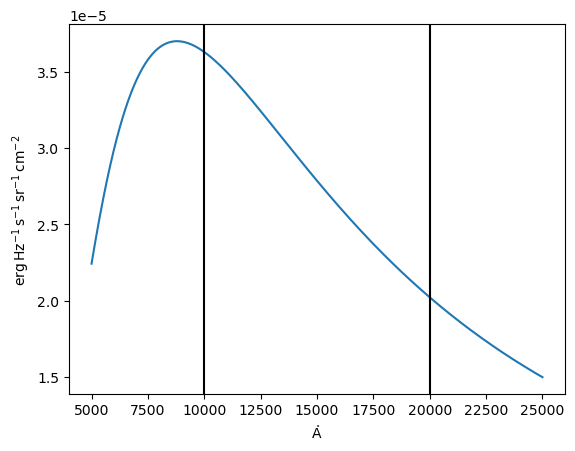

In [12]:
fakewl = np.linspace(5000, 25000,2048*8)*u.angstrom
noiseamp = 0
bbf = modeling.models.BlackBody(5800*u.K)(fakewl)
fakespectrum = Spectrum1D(spectral_axis=fakewl, flux= bbf + np.random.randn(len(bbf))*noiseamp * np.mean(bbf))

plt.plot(fakespectrum.spectral_axis, fakespectrum.flux)
for edge in [10000, 20000]:
    plt.axvline(edge, c='k')

In [40]:
model0 = SpectralNeuralNetwork(fakespectrum, inner_layers=[1024, 512,1024]).to('cpu').to(torch.float64)

test_X, test_Y, test_specs = model0.make_data(50, random=False, progress=True)

train_X, train_Y = model0.make_data(64*4, random=False, progress=True)[:2]
train_data = TensorDataset(train_X, train_Y)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

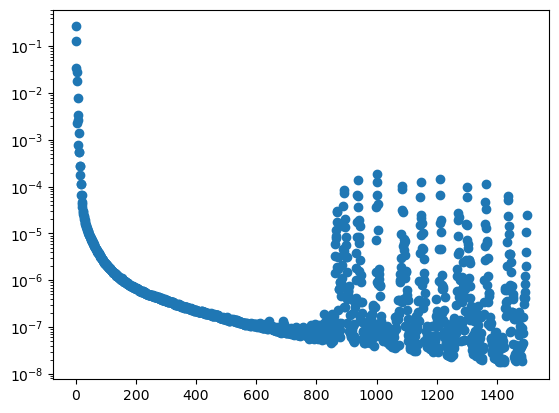

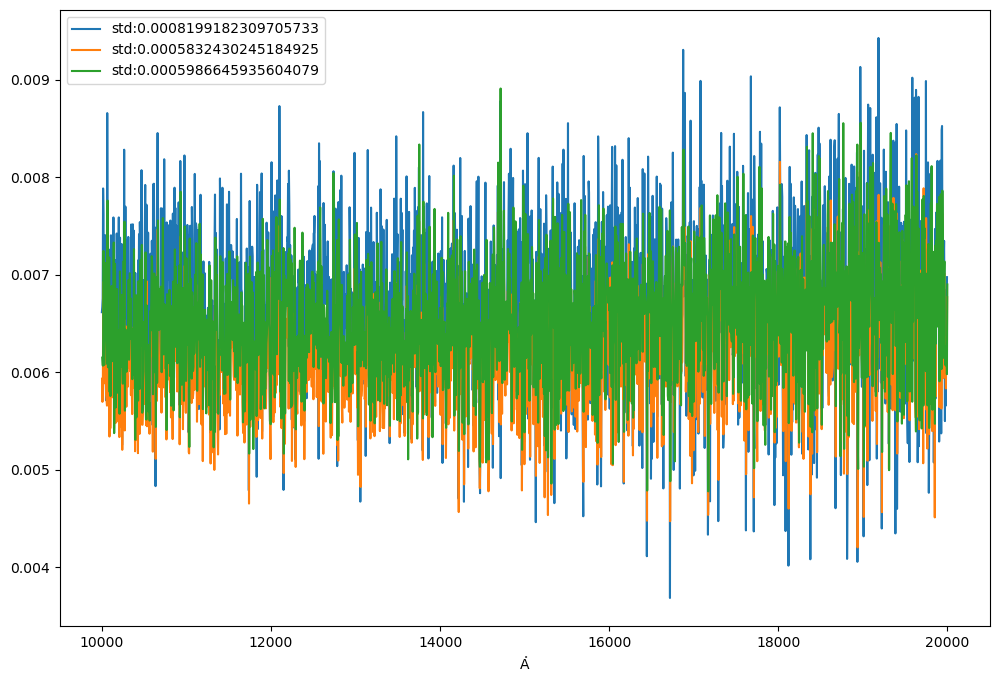

In [43]:
model = deepcopy(model0)

learning_rates = [5e-4]
nepochs = 1500
batch_size = 64

loss_fn = nn.MSELoss()
test_losses = []

for learning_rate in learning_rates:
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    
    for _ in (pbar := tqdm(range(nepochs))):
        model.train()
    
        for X, Y in DataLoader(train_data, batch_size=batch_size, shuffle=True):
            pred = model(X)
            loss = loss_fn(pred, Y)
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
    
        model.eval()
        with torch.no_grad():
            pred = model(test_X)
            test_loss = loss_fn(pred,test_Y).item()
            pbar.set_description(f'test loss={test_loss}')
            test_losses.append(test_loss)

plt.semilogy(test_losses, 'o')
if len(learning_rates) > 1:
    for i in range(len(learning_rates)):
        plt.axvline((i+1)*nepochs, c='k', alpha=.5)

plt.figure(figsize=(12, 8))
for Xi, s in zip(test_X[::20], test_specs[::20]):
    modflux = model(Xi[..., None]).detach().cpu().numpy()[0]/model.outscale
    res = 1 - modflux/s.flux.value
    plt.plot(s.spectral_axis, res, label=f'std:{np.std(res)}')
plt.legend(loc=0)

Now try the same bit with some gaussian noise in the fake spectrum

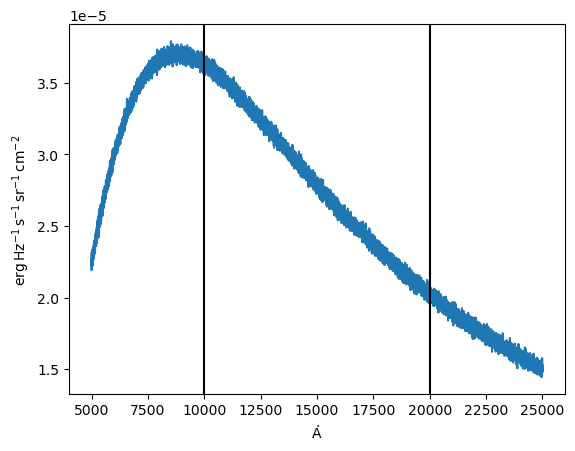

In [13]:
fakewl = np.linspace(5000, 25000,2048*8)*u.angstrom
noiseamp = 0.01
bbf = modeling.models.BlackBody(5800*u.K)(fakewl)
fakespectrum2 = Spectrum1D(spectral_axis=fakewl, flux= bbf + np.random.randn(len(bbf))*noiseamp * np.mean(bbf))

plt.plot(fakespectrum2.spectral_axis, fakespectrum2.flux)
for edge in [10000, 20000]:
    plt.axvline(edge, c='k')

In [15]:
model0 = SpectralNeuralNetwork(fakespectrum2, inner_layers=[1024, 512,1024]).to(device).to(torch.float64)

test_X, test_Y, test_specs = model0.make_data(50, random=False, progress=True)

train_X, train_Y = model0.make_data(64*4, random=True, progress=True)[:2]
train_data = TensorDataset(train_X, train_Y)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

Weight decay?

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

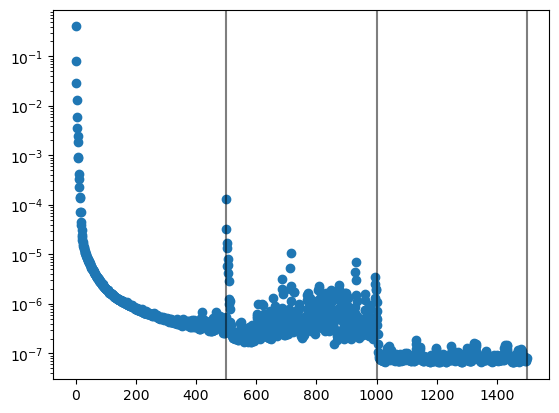

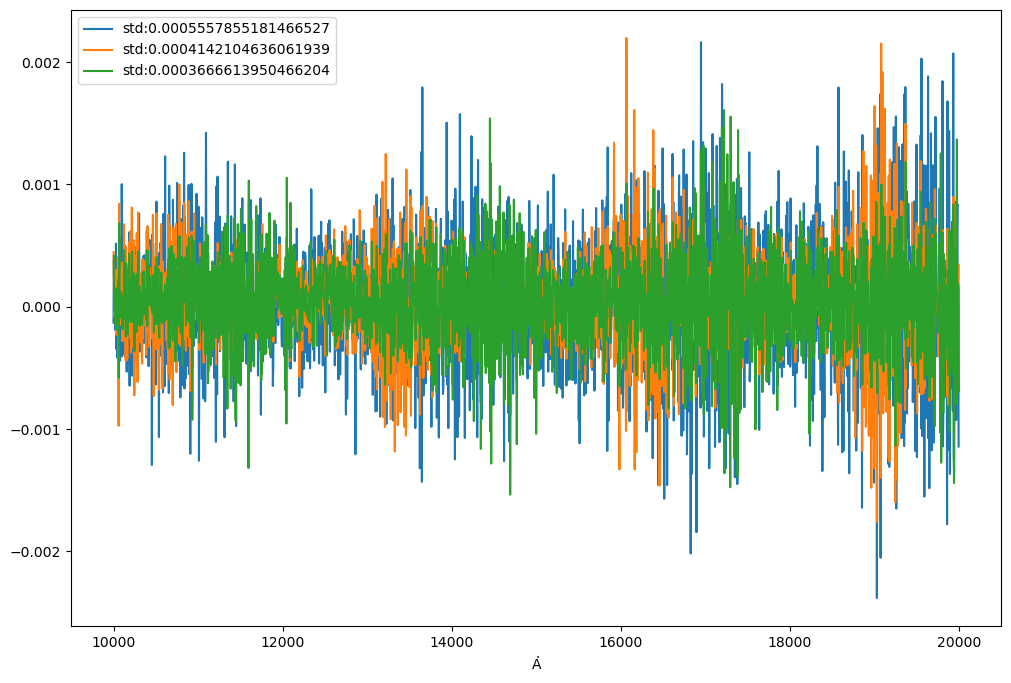

In [21]:
model = deepcopy(model0)

learning_rates = [1e-3, 1e-4, 1e-5]
nepochs = 500
batch_size = 64

loss_fn = nn.MSELoss()
test_losses = []

for learning_rate in learning_rates:
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-3)
    
    for _ in (pbar := tqdm(range(nepochs))):
        model.train()
    
        for X, Y in DataLoader(train_data, batch_size=batch_size, shuffle=True):
            pred = model(X)
            loss = loss_fn(pred, Y)
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
    
        model.eval()
        with torch.no_grad():
            pred = model(test_X)
            test_loss = loss_fn(pred,test_Y).item()
            pbar.set_description(f'test loss={test_loss}')
            test_losses.append(test_loss)

plt.semilogy(test_losses, 'o')
if len(learning_rates) > 1:
    for i in range(len(learning_rates)):
        plt.axvline((i+1)*nepochs, c='k', alpha=.5)

plt.figure(figsize=(12, 8))
for Xi, s in zip(test_X[::20], test_specs[::20]):
    modflux = model(Xi[..., None]).detach().cpu().numpy()[0]/model.outscale
    res = 1 - modflux/s.flux.value
    plt.plot(s.spectral_axis, res, label=f'std:{np.std(res)}')
plt.legend(loc=0)

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

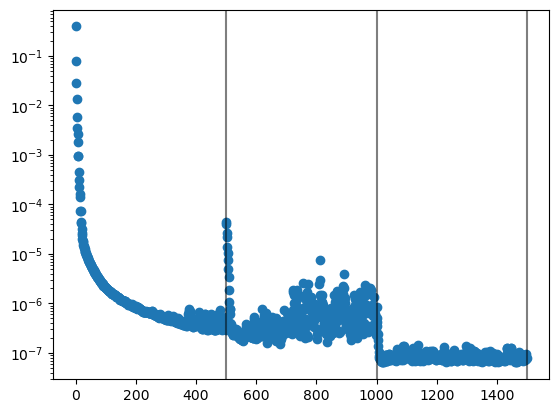

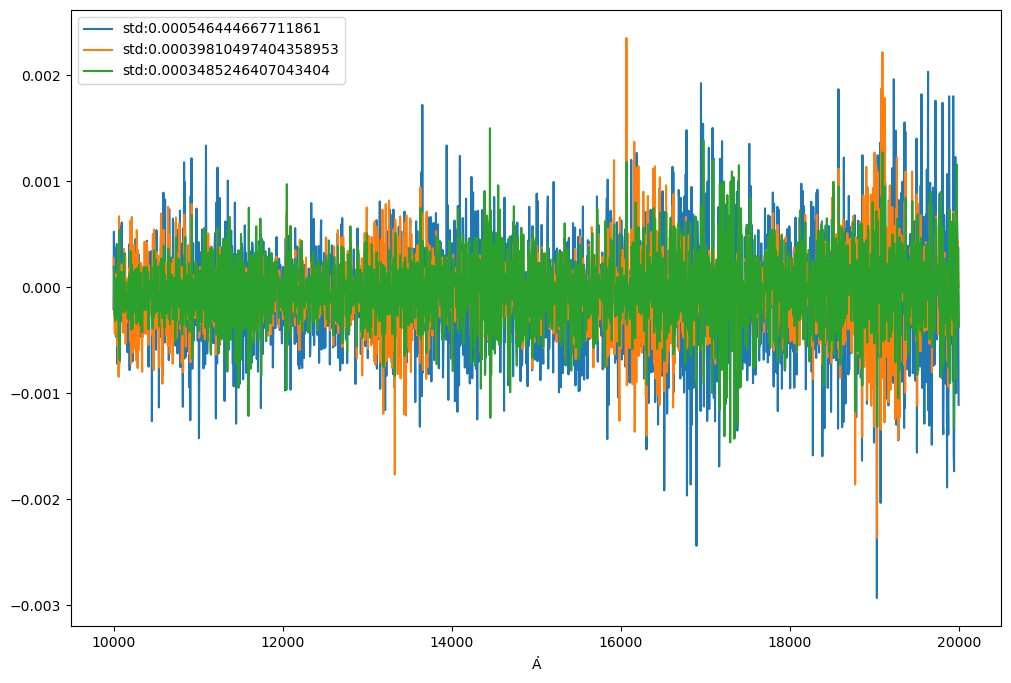

In [19]:
model = deepcopy(model0)

learning_rates = [1e-3, 1e-4, 1e-5]
nepochs = 500
batch_size = 64

loss_fn = nn.MSELoss()
test_losses = []

for learning_rate in learning_rates:
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    
    for _ in (pbar := tqdm(range(nepochs))):
        model.train()
    
        for X, Y in DataLoader(train_data, batch_size=batch_size, shuffle=True):
            pred = model(X)
            loss = loss_fn(pred, Y)
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
    
        model.eval()
        with torch.no_grad():
            pred = model(test_X)
            test_loss = loss_fn(pred,test_Y).item()
            pbar.set_description(f'test loss={test_loss}')
            test_losses.append(test_loss)

plt.semilogy(test_losses, 'o')
if len(learning_rates) > 1:
    for i in range(len(learning_rates)):
        plt.axvline((i+1)*nepochs, c='k', alpha=.5)

plt.figure(figsize=(12, 8))
for Xi, s in zip(test_X[::20], test_specs[::20]):
    modflux = model(Xi[..., None]).detach().cpu().numpy()[0]/model.outscale
    res = 1 - modflux/s.flux.value
    plt.plot(s.spectral_axis, res, label=f'std:{np.std(res)}')
plt.legend(loc=0)

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

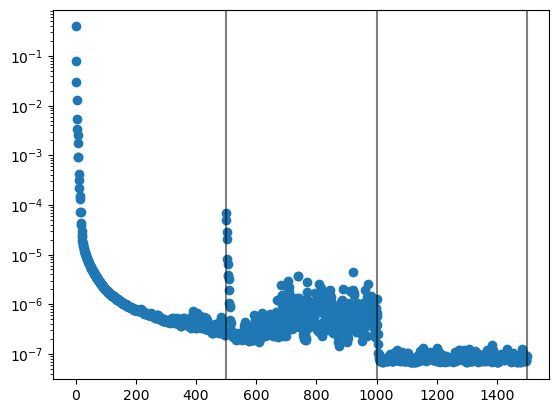

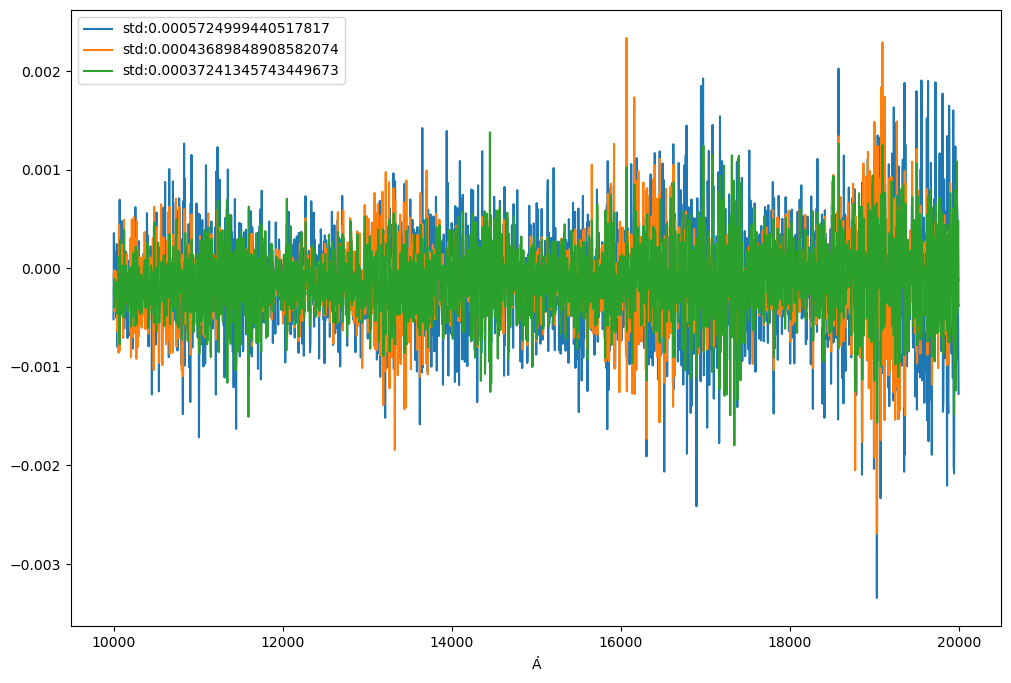

In [20]:
model = deepcopy(model0)

learning_rates = [1e-3, 1e-4, 1e-5]
nepochs = 500
batch_size = 64

loss_fn = nn.MSELoss()
test_losses = []

for learning_rate in learning_rates:
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0)
    
    for _ in (pbar := tqdm(range(nepochs))):
        model.train()
    
        for X, Y in DataLoader(train_data, batch_size=batch_size, shuffle=True):
            pred = model(X)
            loss = loss_fn(pred, Y)
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
    
        model.eval()
        with torch.no_grad():
            pred = model(test_X)
            test_loss = loss_fn(pred,test_Y).item()
            pbar.set_description(f'test loss={test_loss}')
            test_losses.append(test_loss)

plt.semilogy(test_losses, 'o')
if len(learning_rates) > 1:
    for i in range(len(learning_rates)):
        plt.axvline((i+1)*nepochs, c='k', alpha=.5)

plt.figure(figsize=(12, 8))
for Xi, s in zip(test_X[::20], test_specs[::20]):
    modflux = model(Xi[..., None]).detach().cpu().numpy()[0]/model.outscale
    res = 1 - modflux/s.flux.value
    plt.plot(s.spectral_axis, res, label=f'std:{np.std(res)}')
plt.legend(loc=0)

CyclicLR?

  0%|          | 0/2500 [00:00<?, ?it/s]

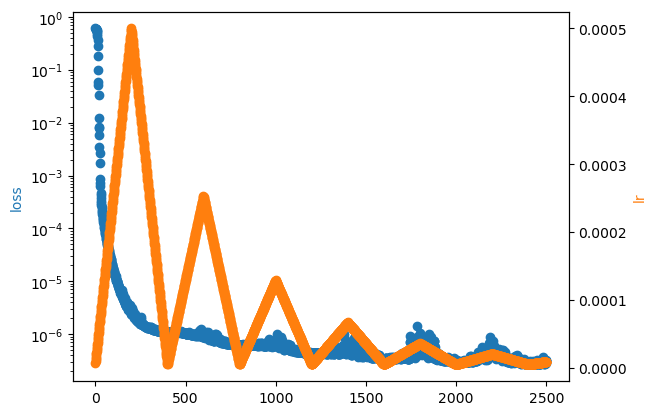

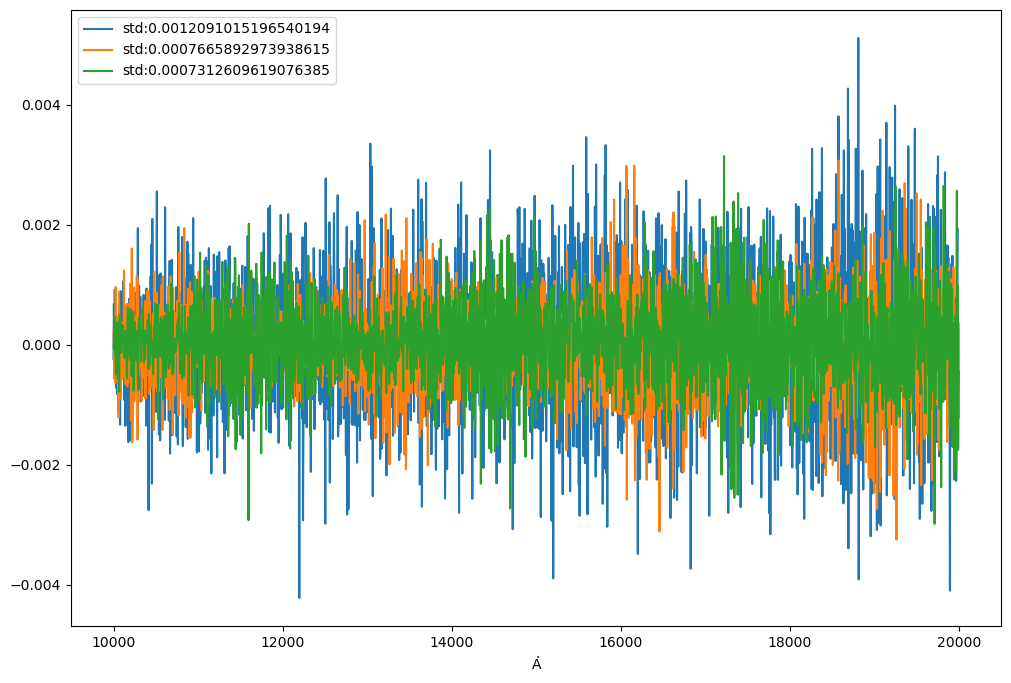

In [74]:
model = deepcopy(model0)

nepochs = 2500
batch_size = 64
iperepoch = len(list(DataLoader(train_data, batch_size=batch_size, shuffle=True)))

loss_fn = nn.MSELoss()
train_losses = []
test_losses = []
test_lrs = []

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-7, weight_decay=1e-3)
optimizer.zero_grad()

scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=5e-6, max_lr=5e-4, step_size_up=200*iperepoch, mode='triangular2')

for _ in (pbar := tqdm(range(nepochs))):
    model.train()

    for X, Y in DataLoader(train_data, batch_size=batch_size, shuffle=True):
        pred = model(X)
        loss = loss_fn(pred, Y)
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        scheduler.step()

        train_losses.append(loss.item())

    model.eval()
    with torch.no_grad():
        pred = model(test_X)
        test_loss = loss_fn(pred,test_Y).item()
        pbar.set_description(f'test loss={test_loss:.3e}, lr={scheduler.get_last_lr()[0]:.3e}')
        test_losses.append(test_loss)
        test_lrs.append(scheduler.get_last_lr()[0])


plt.semilogy(test_losses, 'o', c='C0')
plt.ylabel('loss', color='C0')
plt.twinx()
plt.plot(test_lrs, 'o', c='C1')
plt.ylabel('lr', color='C1')

plt.figure(figsize=(12, 8))
for Xi, s in zip(test_X[::20], test_specs[::20]):
    modflux = model(Xi[..., None]).detach().cpu().numpy()[0]/model.outscale
    res = 1 - modflux/s.flux.value
    plt.plot(s.spectral_axis, res, label=f'std:{np.std(res)}')
plt.legend(loc=0)

What about the eps parameter? Try two identical runs with different eps

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

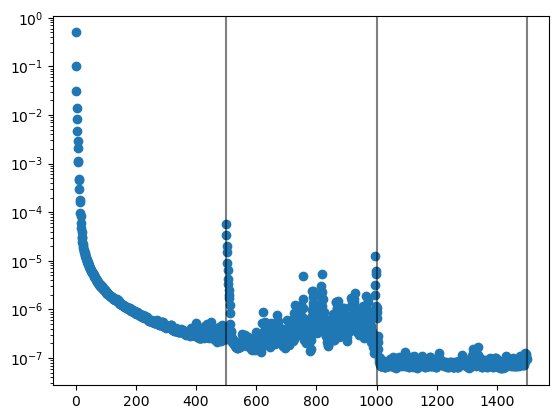

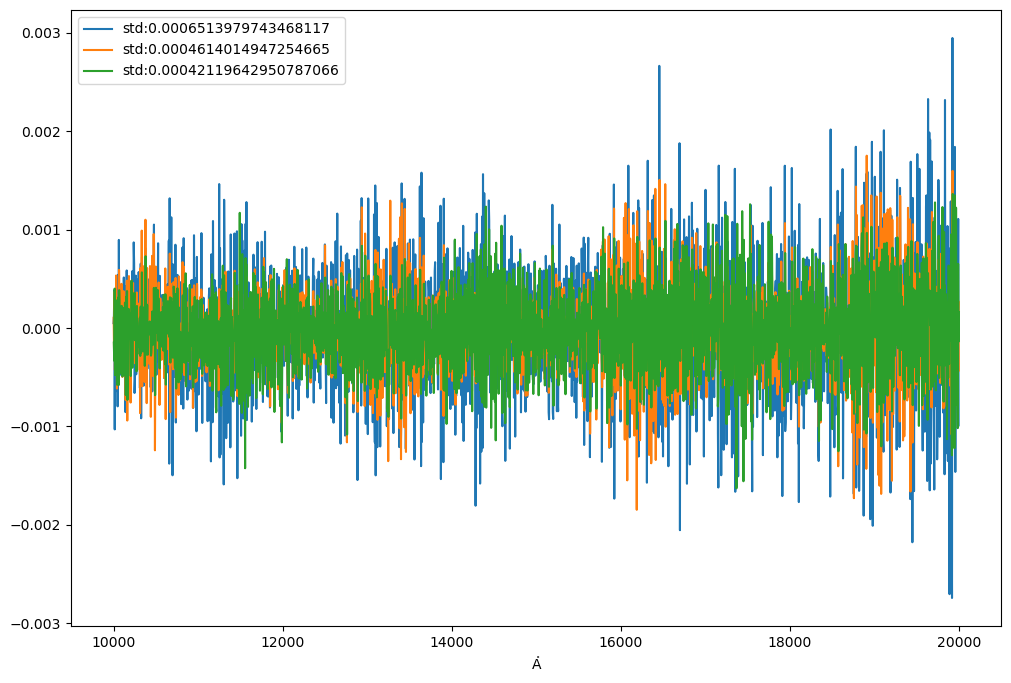

In [16]:
model = deepcopy(model0)

learning_rates = [1e-3, 1e-4, 1e-5]
nepochs = 500
batch_size = 64

loss_fn = nn.MSELoss()
test_losses = []

for learning_rate in learning_rates:
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0, eps=1e-8)
    
    for _ in (pbar := tqdm(range(nepochs))):
        model.train()
    
        for X, Y in DataLoader(train_data, batch_size=batch_size, shuffle=True):
            pred = model(X)
            loss = loss_fn(pred, Y)
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
    
        model.eval()
        with torch.no_grad():
            pred = model(test_X)
            test_loss = loss_fn(pred,test_Y).item()
            pbar.set_description(f'test loss={test_loss}')
            test_losses.append(test_loss)

plt.semilogy(test_losses, 'o')
if len(learning_rates) > 1:
    for i in range(len(learning_rates)):
        plt.axvline((i+1)*nepochs, c='k', alpha=.5)

plt.figure(figsize=(12, 8))
for Xi, s in zip(test_X[::20], test_specs[::20]):
    modflux = model(Xi[..., None]).detach().cpu().numpy()[0]/model.outscale
    res = 1 - modflux/s.flux.value
    plt.plot(s.spectral_axis, res, label=f'std:{np.std(res)}')
plt.legend(loc=0)

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

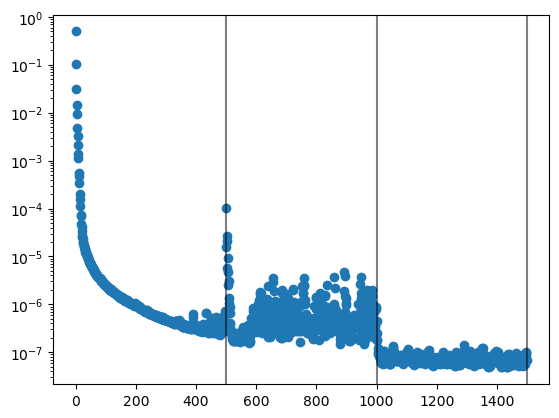

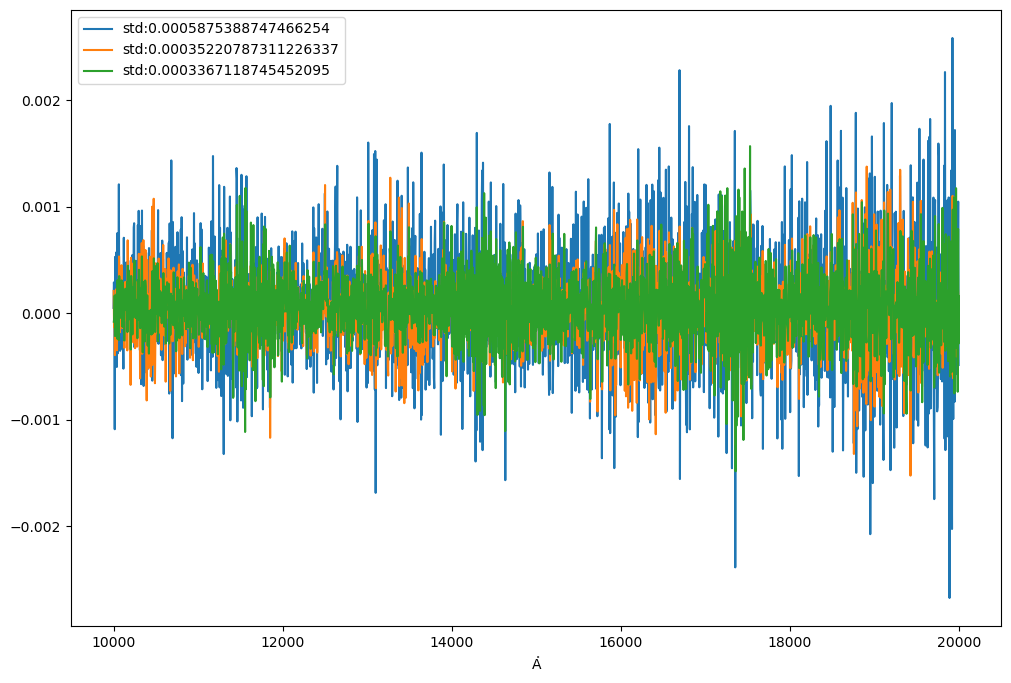

In [18]:
model = deepcopy(model0)

learning_rates = [1e-3, 1e-4, 1e-5]
nepochs = 500
batch_size = 64

loss_fn = nn.MSELoss()
test_losses = []

for learning_rate in learning_rates:
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0, eps=1e-10)
    
    for _ in (pbar := tqdm(range(nepochs))):
        model.train()
    
        for X, Y in DataLoader(train_data, batch_size=batch_size, shuffle=True):
            pred = model(X)
            loss = loss_fn(pred, Y)
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
    
        model.eval()
        with torch.no_grad():
            pred = model(test_X)
            test_loss = loss_fn(pred,test_Y).item()
            pbar.set_description(f'test loss={test_loss}')
            test_losses.append(test_loss)

plt.semilogy(test_losses, 'o')
if len(learning_rates) > 1:
    for i in range(len(learning_rates)):
        plt.axvline((i+1)*nepochs, c='k', alpha=.5)

plt.figure(figsize=(12, 8))
for Xi, s in zip(test_X[::20], test_specs[::20]):
    modflux = model(Xi[..., None]).detach().cpu().numpy()[0]/model.outscale
    res = 1 - modflux/s.flux.value
    plt.plot(s.spectral_axis, res, label=f'std:{np.std(res)}')
plt.legend(loc=0)